In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# EMNIST Balanced 47-class label to character map (from EMNIST site)
emnist_balanced_map = {
    0: '0',  1: '1',  2: '2',  3: '3',  4: '4',
    5: '5',  6: '6',  7: '7',  8: '8',  9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
    15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
    25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
    35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q',
    45: 'r', 46: 't'
}

def save_emnist_balanced(csv_path, output_dir, split_name, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)
    print(f"🔄 Converting {split_name} EMNIST Balanced data...")

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        # Get the corresponding character
        class_char = emnist_balanced_map.get(label, f"UNK_{label}")

        label_dir = os.path.join(output_dir, split_name, class_char)
        os.makedirs(label_dir, exist_ok=True)

        # Fix orientation
        image = np.transpose(image, (1, 0))  # rotate -90 degrees
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)

        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# ------------------------------
# Usage
# ------------------------------
train_csv = '/kaggle/input/emnist/emnist-balanced-train.csv'
test_csv = '/kaggle/input/emnist/emnist-balanced-test.csv'
output_base = './emnist_balanced_images'

save_emnist_balanced(train_csv, output_base, 'train')
save_emnist_balanced(test_csv, output_base, 'test')

print("✅ EMNIST Balanced images saved with correct orientation and labels!")

🔄 Converting train EMNIST Balanced data...


100%|██████████| 112800/112800 [00:17<00:00, 6292.30it/s]


🔄 Converting test EMNIST Balanced data...


100%|██████████| 18800/18800 [00:02<00:00, 6497.62it/s]

✅ EMNIST Balanced images saved with correct orientation and labels!


In [3]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# ------------------------------
# Step 3: Split Train → Train + Val (15%)
# ------------------------------
print("🔧 Splitting train into train + val...")

train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
os.makedirs(val_dir, exist_ok=True)

for char_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, char_class)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.15, random_state=42)

    val_class_dir = os.path.join(val_dir, char_class)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in val_imgs:
        src = os.path.join(class_path, img)
        dst = os.path.join(val_class_dir, img)
        os.rename(src, dst)

print("✅ Split completed. Train, Val, and Test sets created.")

🔧 Splitting train into train + val...
✅ Split completed. Train, Val, and Test sets created.


📷 Visualizing from Train Set EMNIST Balanced Samples...


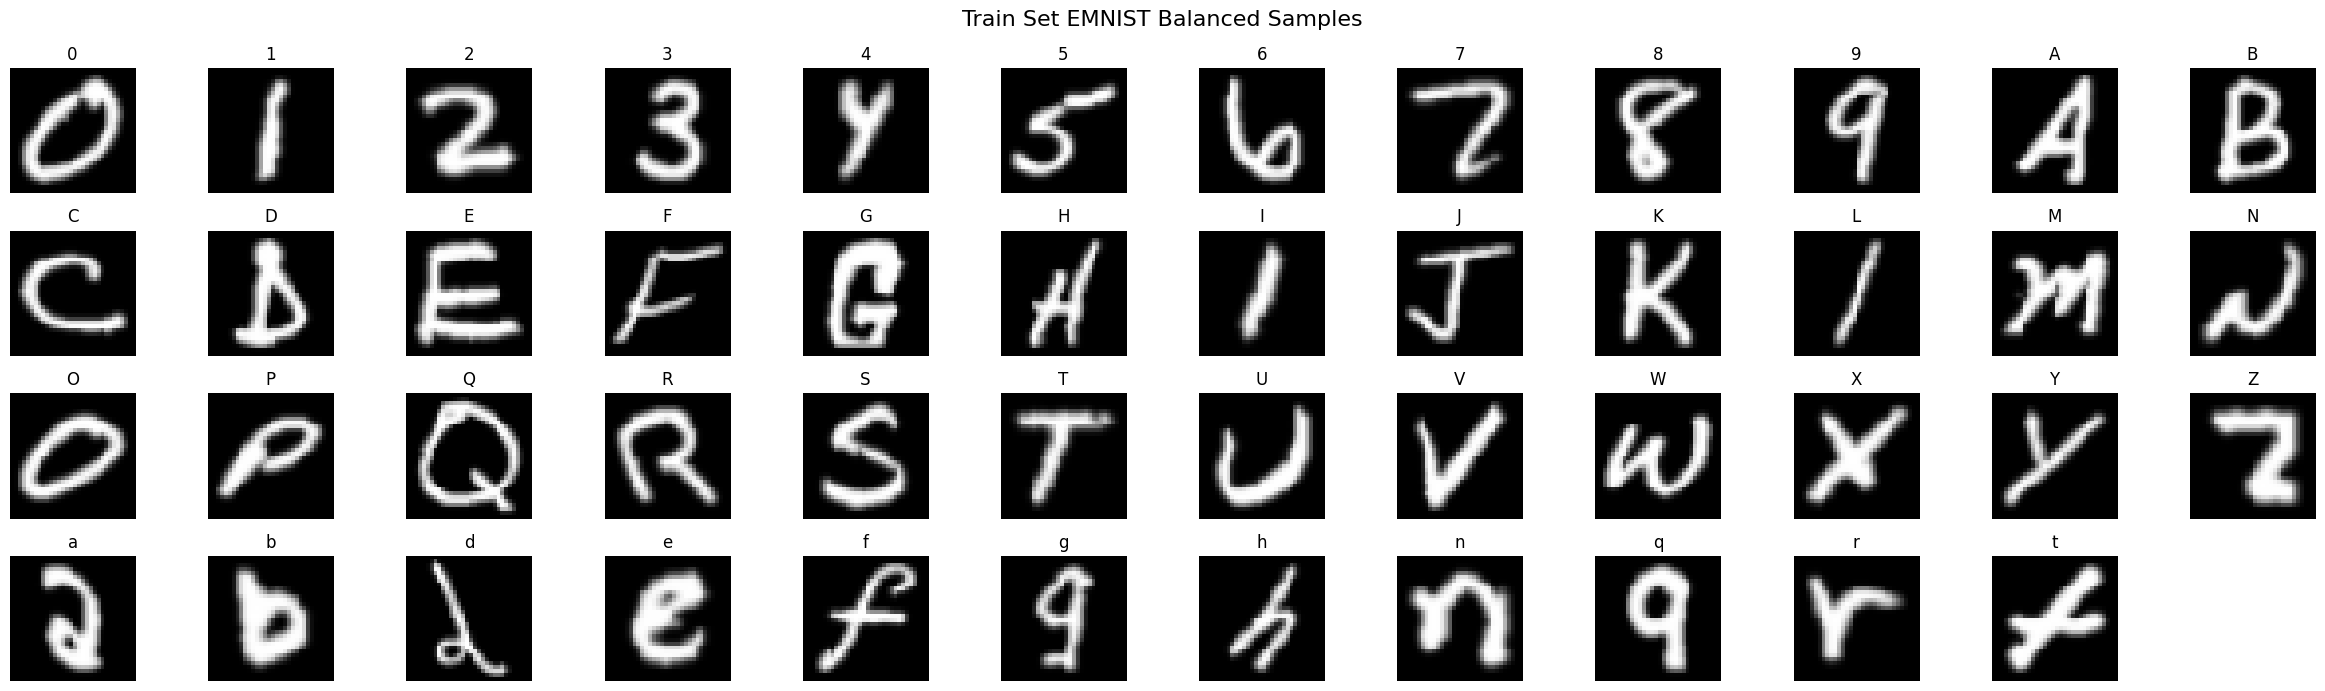

📷 Visualizing from Validation Set EMNIST Balanced Samples...


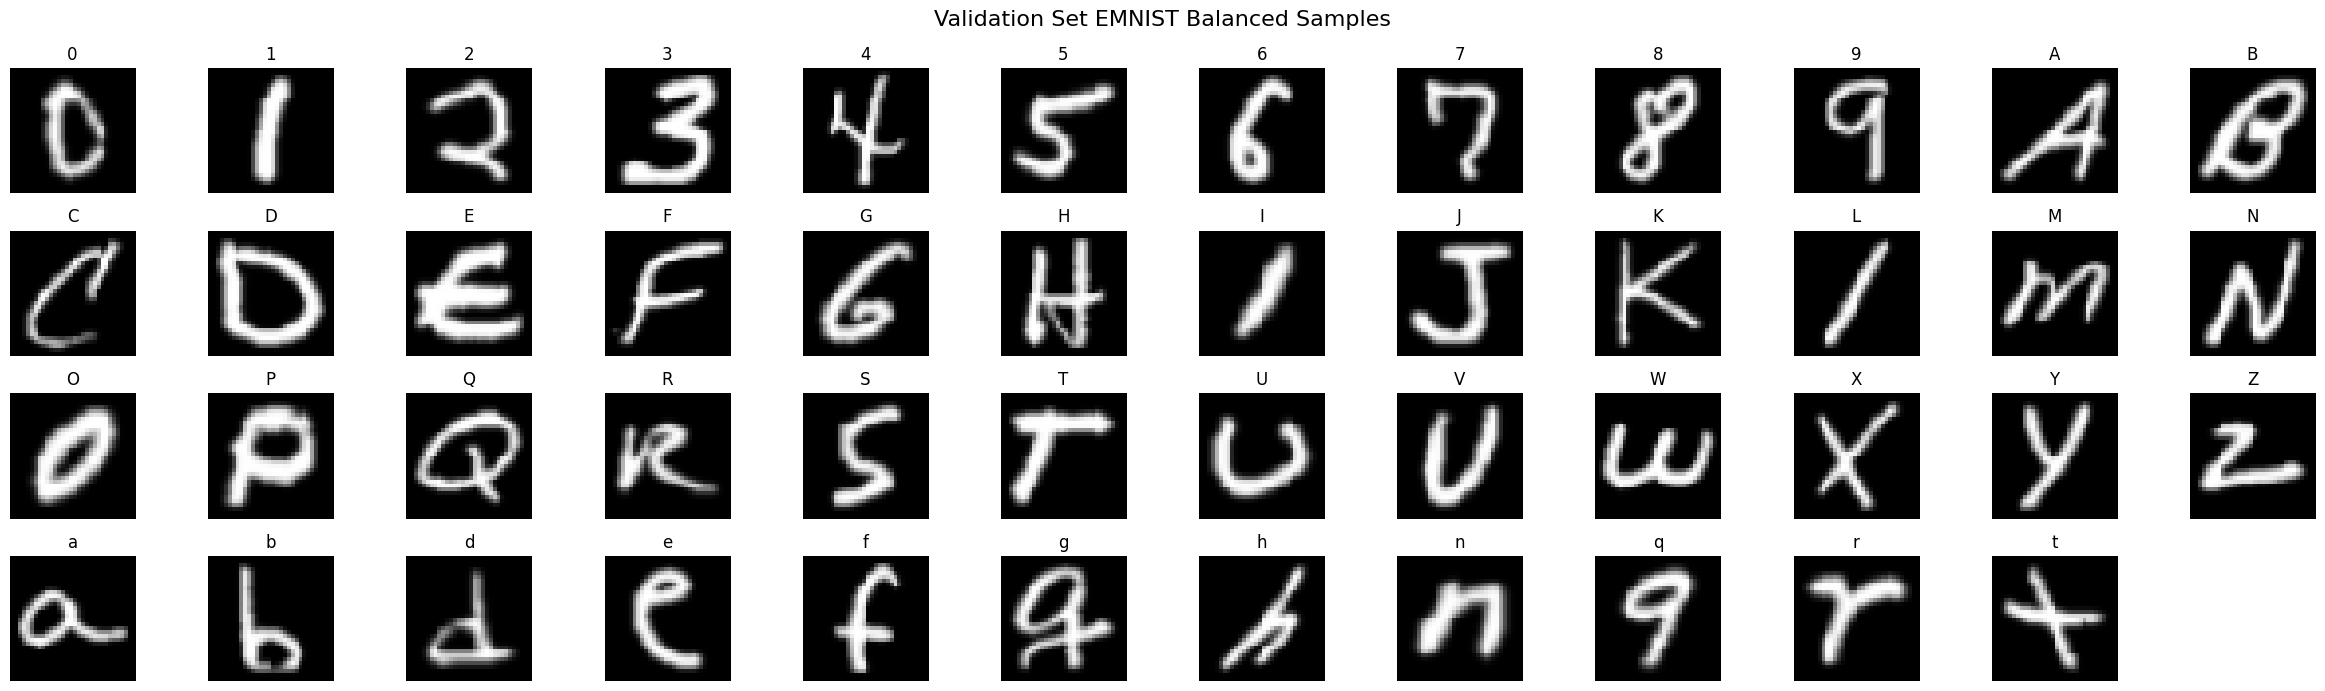

📷 Visualizing from Test Set EMNIST Balanced Samples...


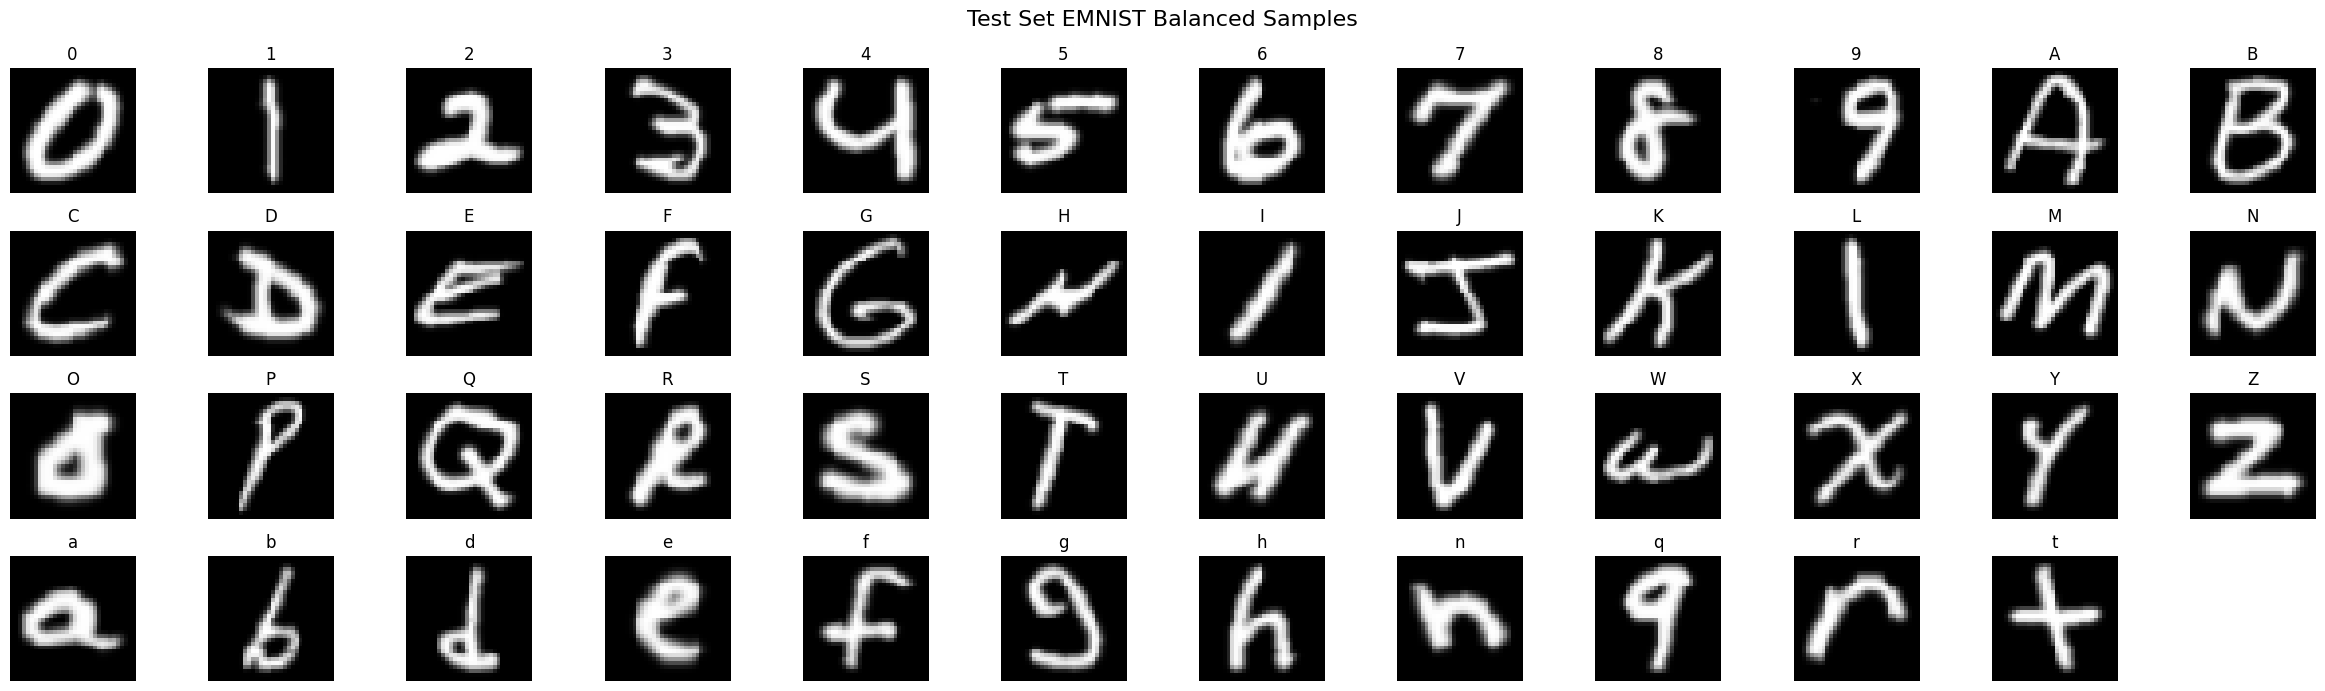

In [4]:
import os
import cv2
import matplotlib.pyplot as plt

# ------------------------------
# Visualize EMNIST Balanced 47 classes
# ------------------------------
def visualize_samples_emnist_balanced(folder, title):
    print(f"📷 Visualizing from {title}...")

    # Define exact EMNIST Balanced classes
    digits = [str(d) for d in range(10)]
    uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
    lowercase = ['a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']
    class_order = digits + uppercase + lowercase  # Total: 47 classes

    plt.figure(figsize=(24, 7))  # Adjust figure size
    shown = 0

    for class_name in class_order:
        class_dir = os.path.join(folder, class_name)
        if not os.path.isdir(class_dir):
            continue
        images = os.listdir(class_dir)
        if not images:
            continue
        img_path = os.path.join(class_dir, images[0])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(4, 12, shown + 1)  # 4 rows × 12 = 48 (1 extra)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name}")
        plt.axis('off')
        shown += 1

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 🔍 Visualize samples from train/val/test
visualize_samples_emnist_balanced(os.path.join(output_base, 'train'), "Train Set EMNIST Balanced Samples")
visualize_samples_emnist_balanced(os.path.join(output_base, 'val'), "Validation Set EMNIST Balanced Samples")
visualize_samples_emnist_balanced(os.path.join(output_base, 'test'), "Test Set EMNIST Balanced Samples")


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 80
num_classes = 62  # Update if using fewer classes


# Paths after splitting
train_path = "/kaggle/working/emnist_balanced_images/train"
val_path   = "/kaggle/working/emnist_balanced_images/val"
test_path  = "/kaggle/working/emnist_balanced_images/test"

# Augmented training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=8,           # Slightly more rotation
    zoom_range=0.10,            # Increased zoom variation
    width_shift_range=0.08,     # Allow more width shifting
    height_shift_range=0.08,    # Allow more height shifting
    shear_range=0.10,           # Stronger shearing
    brightness_range=(0.8, 1.2),# Add brightness variation
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    color_mode='grayscale',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

2025-06-13 17:48:55.093658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749836935.332087      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749836935.399798      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 95880 images belonging to 47 classes.
Found 16920 images belonging to 47 classes.
Found 18800 images belonging to 47 classes.


In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


def build_scriptnetx_large(input_shape=(32, 32, 1), num_classes=47):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.35)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.4)(x)

    # Block 4 (Extra)
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.5)(x)

    # Dense layer
    x = Flatten()(x)
    x = Dense(1024, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs, name='ScriptNetX_Large')

    
print("Model initialized")

Model initialized


In [8]:
# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_scriptnetx_large(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

I0000 00:00:1749837007.985206      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749837007.985935      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ScriptNetX_Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,495,870 (17.15 MB)

 Trainable params: 4,491,006 (17.13 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [10]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("best_scriptnet_large_EMNISTbalanced.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
1498/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5026 - loss: 1.8222
Epoch 1: val_accuracy improved from -inf to 0.85946, saving model to best_scriptnet_large_EMNISTbalanced.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 85s 57ms/step - accuracy: 0.5028 - loss: 1.8211 - val_accuracy: 0.8595 - val_loss: 0.4227 - learning_rate: 0.0010
Epoch 2/80
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8197 - loss: 0.5177
Epoch 2: val_accuracy improved from 0.85946 to 0.87577, saving model to best_scriptnet_large_EMNISTbalanced.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 75s 50ms/step - accuracy: 0.8198 - loss: 0.5177 - val_accuracy: 0.8758 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 3/80
1498/1499 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8374 - loss: 0.4552
Epoch 3: val_accuracy improved from 0.87577 to 0.88209, saving model to best_scriptnet_large_EMNISTbalanced.h5
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 75s 50ms/step - accuracy: 0.8374 - loss: 0.4551 - val_accuracy: 0.8821 - val_loss:

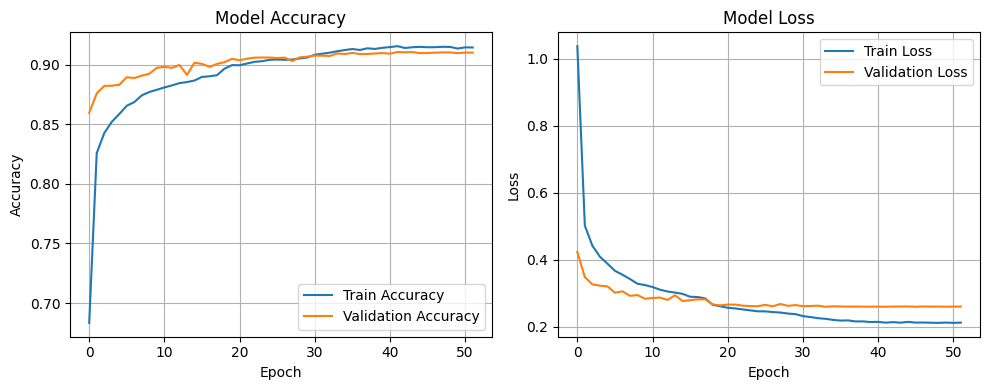

In [11]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")

294/294 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           0     0.6426    0.8225    0.7215       400
           1     0.5475    0.7350    0.6275       400
           2     0.9455    0.9100    0.9274       400
           3     0.9950    0.9950    0.9950       400
           4     0.9724    0.9700    0.9712       400
           5     0.9573    0.9525    0.9549       400
           6     0.9579    0.9675    0.9627       400
           7     0.9827    0.9950    0.9888       400
           8     0.9726    0.9775    0.9751       400
           9     0.7073    0.9000    0.7921       400
           A     0.9779    0.9950    0.9864       400
           B     0.9777    0.9875    0.9826       400
           C     0.9747    0.9650    0.9698       400
           D     0.9502    0.9550    0.9526       400
           E     0.9900    0.9900    0.9900       400
           F     0.7469    0.6050    0.6685       400
           G 

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predictions & ground truths (you already have these)
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = [str(i) for i in range(47)]  # adjust for your classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# cm shape: (num_classes, num_classes)

num_classes = len(class_names)
sensitivities = []
specificities = []
supports = np.sum(cm, axis=1)  # Number of true samples per class

for i in range(num_classes):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)

# Weighted sensitivity and specificity per class = metric * support
weighted_sensitivities = sensitivities * supports
weighted_specificities = specificities * supports

# Print results nicely
print(f"{'Class':>5} | {'Support':>7} | {'Sensitivity':>12} | {'Weighted Sensitivity':>20} | {'Specificity':>12} | {'Weighted Specificity':>20}")
print("-" * 90)
for i, cls in enumerate(class_names):
    print(f"{cls:>5} | {supports[i]:7} | {sensitivities[i]:12.4f} | {weighted_sensitivities[i]:20.4f} | {specificities[i]:12.4f} | {weighted_specificities[i]:20.4f}")


294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Class | Support |  Sensitivity | Weighted Sensitivity |  Specificity | Weighted Specificity
------------------------------------------------------------------------------------------
    0 |     400 |       0.8225 |             329.0000 |       0.9901 |             396.0217
    1 |     400 |       0.7350 |             294.0000 |       0.9868 |             394.7174
    2 |     400 |       0.9100 |             364.0000 |       0.9989 |             399.5435
    3 |     400 |       0.9950 |             398.0000 |       0.9999 |             399.9565
    4 |     400 |       0.9700 |             388.0000 |       0.9994 |             399.7609
    5 |     400 |       0.9525 |             381.0000 |       0.9991 |             399.6304
    6 |     400 |       0.9675 |             387.0000 |       0.9991 |             399.6304
    7 |     400 |       0.9950 |             398.0000 |       0.9996 |             399.8478
    8 |     400 |       0.9775 |       

294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


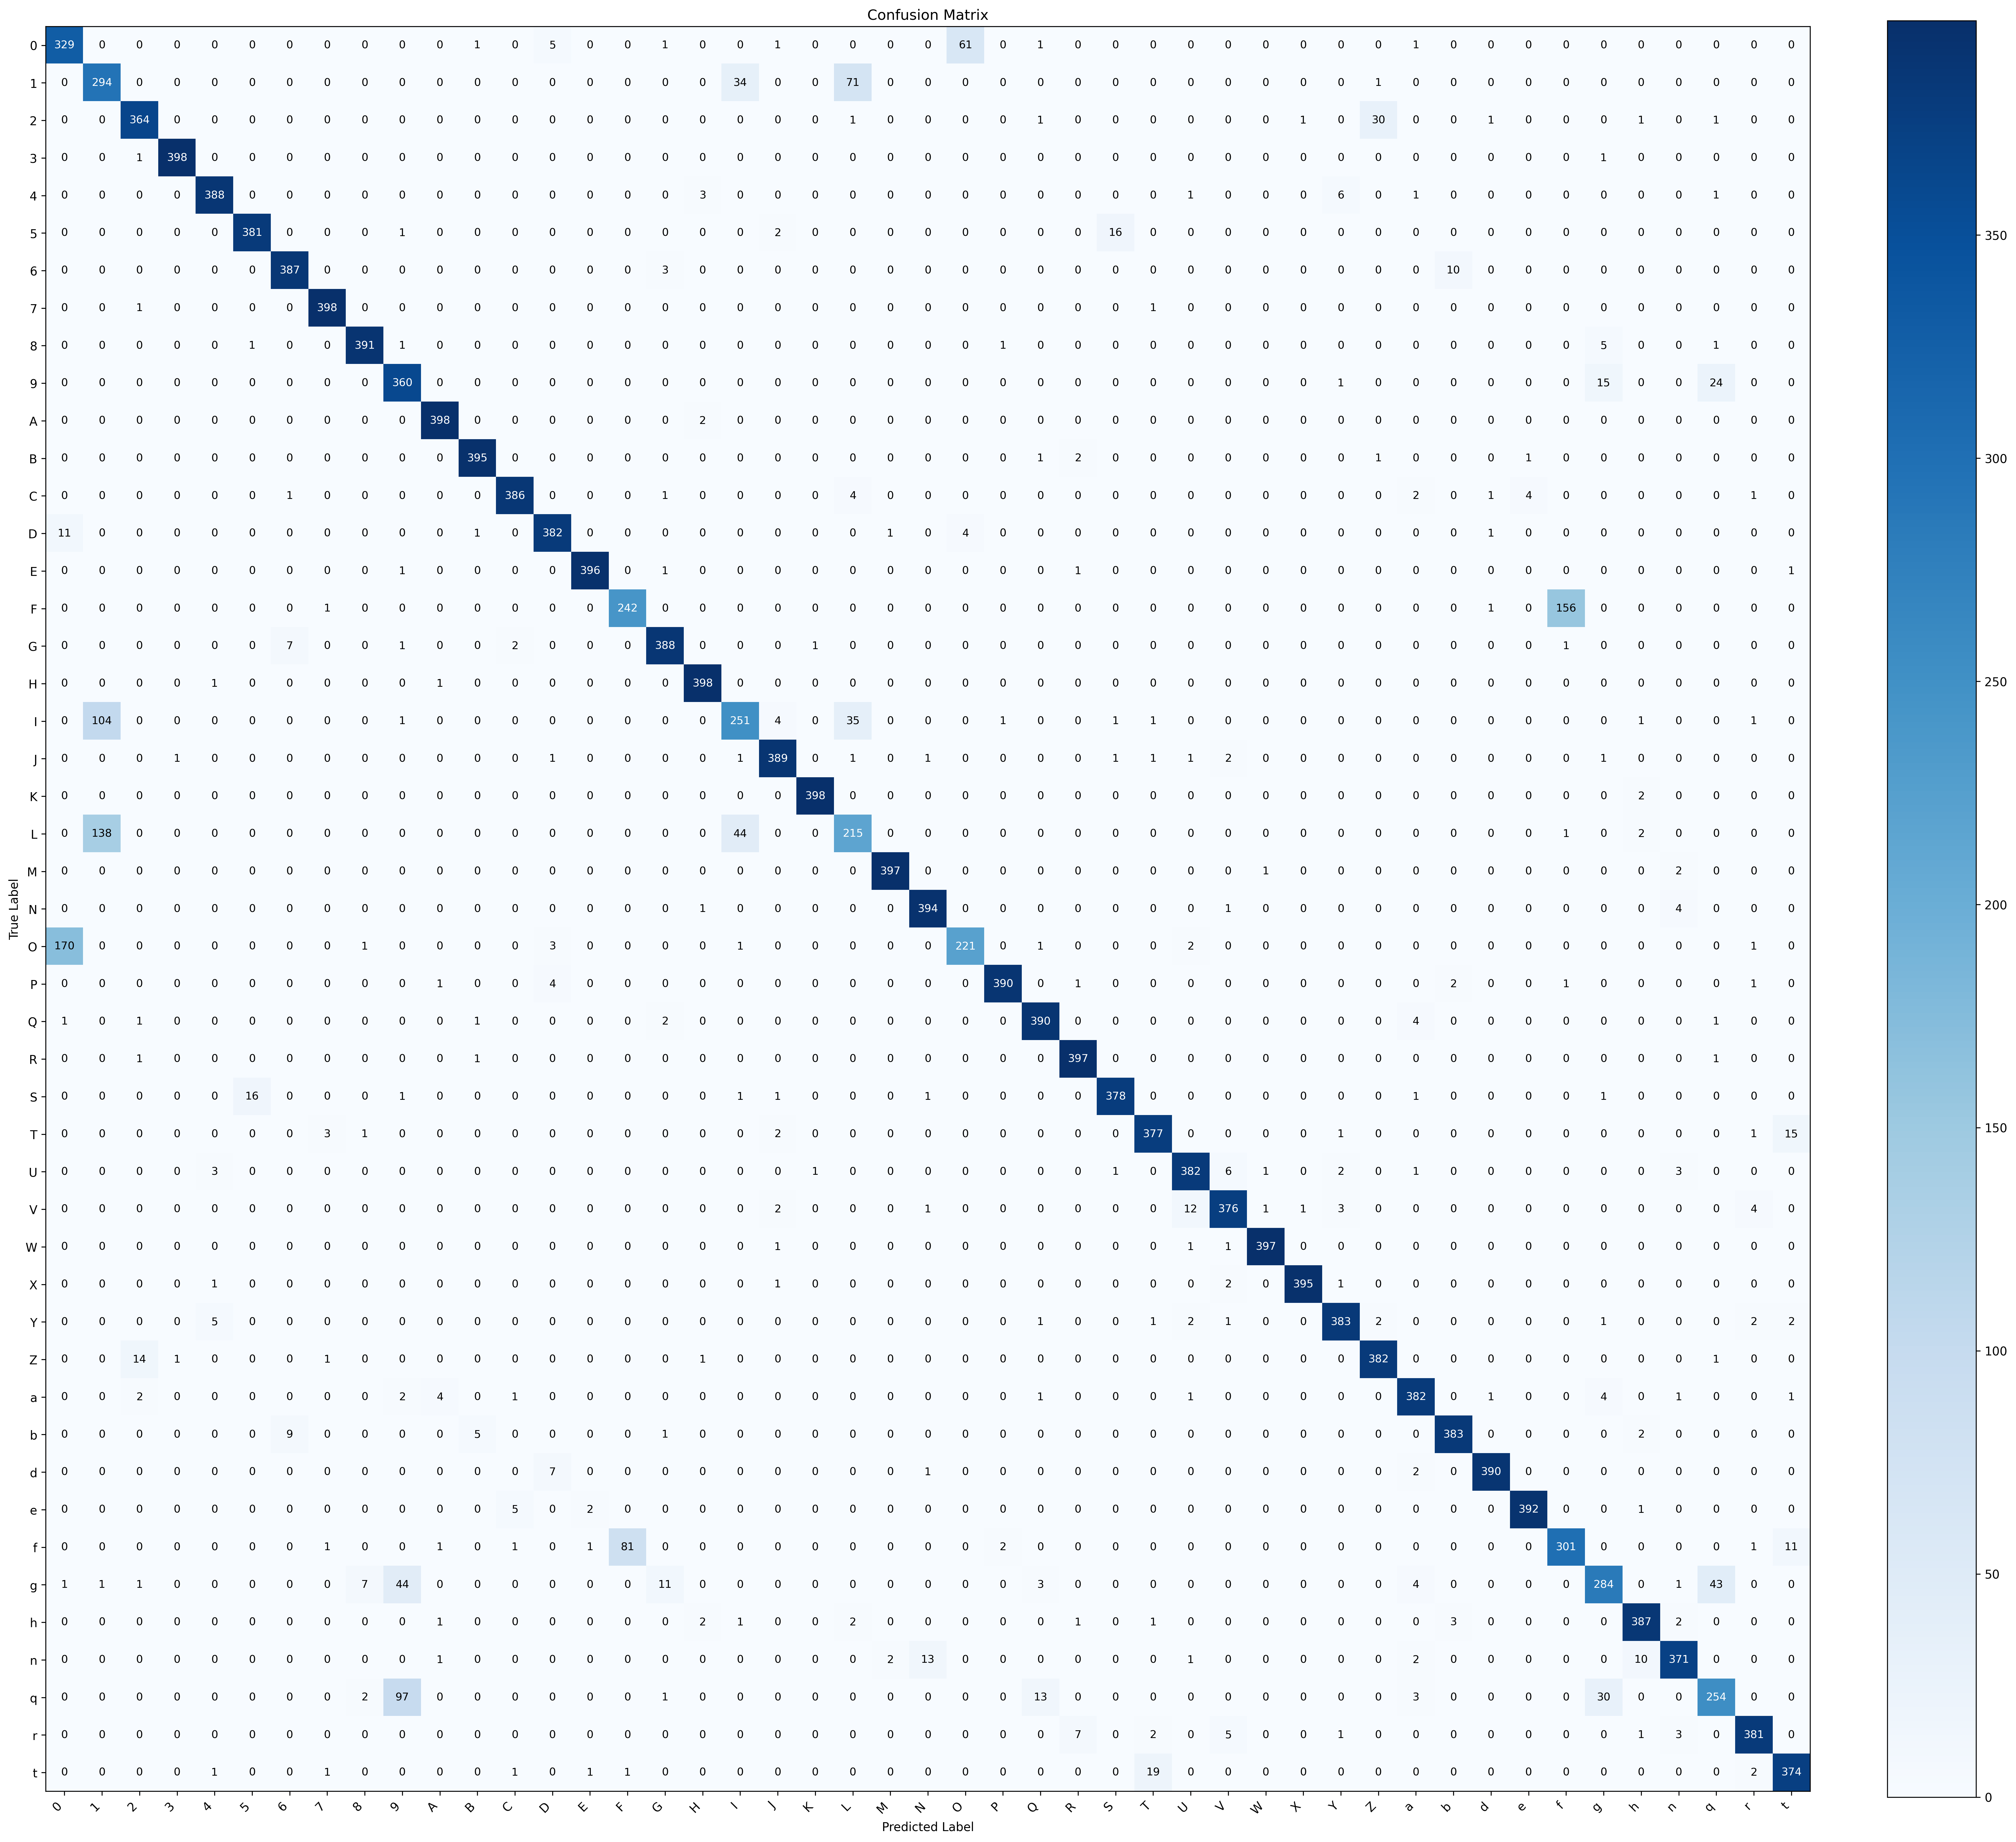

✅ Confusion matrix saved to: confusion_matrix.png
📋 Classification Report:

              precision    recall  f1-score   support

           0     0.6426    0.8225    0.7215       400
           1     0.5475    0.7350    0.6275       400
           2     0.9455    0.9100    0.9274       400
           3     0.9950    0.9950    0.9950       400
           4     0.9724    0.9700    0.9712       400
           5     0.9573    0.9525    0.9549       400
           6     0.9579    0.9675    0.9627       400
           7     0.9827    0.9950    0.9888       400
           8     0.9726    0.9775    0.9751       400
           9     0.7073    0.9000    0.7921       400
           A     0.9779    0.9950    0.9864       400
           B     0.9777    0.9875    0.9826       400
           C     0.9747    0.9650    0.9698       400
           D     0.9502    0.9550    0.9526       400
           E     0.9900    0.9900    0.9900       400
           F     0.7469    0.6050    0.6685       400
     

<Figure size 640x480 with 0 Axes>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve, auc
)
import pandas as pd
from sklearn.preprocessing import label_binarize
from math import ceil

def plot_confusion_matrix_general(
    y_true, y_pred, class_labels,
    title="Confusion Matrix",
    normalize=False,
    cmap='Blues',
    dpi=150,
    show_grid=False
):
    num_classes = len(class_labels)
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cell_scale = 0.5
    fig_width = min(25, max(10, num_classes * cell_scale))
    fig_height = min(25, max(10, num_classes * cell_scale))

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046 * fig_height / fig_width, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

    ax.set(
        xticks=np.arange(num_classes),
        yticks=np.arange(num_classes),
        xticklabels=class_labels,
        yticklabels=class_labels,
        xlabel='Predicted Label',
        ylabel='True Label',
        title=title
    )

    tick_font = max(7, 14 - num_classes // 10)
    rotation_angle = 45 if num_classes > 10 else 0
    plt.setp(ax.get_xticklabels(), rotation=rotation_angle, ha="right", fontsize=tick_font)
    plt.setp(ax.get_yticklabels(), fontsize=tick_font)

    if show_grid:
        ax.set_xticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(num_classes + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
        ax.tick_params(which="minor", bottom=False, left=False)
    else:
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    annotation_font = max(6, 13 - num_classes // 10)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            ax.text(j, i, val,
                    ha="center", va="center",
                    fontsize=annotation_font,
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def plot_roc_curves(y_true, y_pred_probs, class_names, dpi=150, group_size=22, export_base_path=None):
    """
    Plot ROC curves for each class in manageable groups.

    Parameters:
    - y_true: Ground truth labels (integers)
    - y_pred_probs: Predicted probabilities (num_samples x num_classes)
    - class_names: List of class names
    - dpi: DPI for the figures
    - group_size: How many ROC curves per page
    - export_base_path: If given, saves each plot page to base_path_pageX.png
    """
    num_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    total_groups = ceil(num_classes / group_size)

    for group_idx in range(total_groups):
        start = group_idx * group_size
        end = min((group_idx + 1) * group_size, num_classes)

        plt.figure(figsize=(10, 8), dpi=dpi)
        colors = plt.cm.get_cmap('tab20', end - start)

        for i, class_i in enumerate(range(start, end)):
            if len(np.unique(y_true_bin[:, class_i])) > 1:
                fpr, tpr, _ = roc_curve(y_true_bin[:, class_i], y_pred_probs[:, class_i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, color=colors(i), lw=2,
                         label=f"{class_names[class_i]} (AUC = {roc_auc:.3f})")
            else:
                print(f"Skipping ROC for class '{class_names[class_i]}' (no positives).")

        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([-0.01, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curves: Classes {start}–{end - 1}', fontsize=14)
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.tight_layout()

        if export_base_path:
            path = f"{export_base_path}_page{group_idx+1}.png"
            plt.savefig(path, dpi=dpi)
            print(f"✅ ROC group saved to: {path}")

        plt.show()

def evaluate_model(
    model, test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path=None,
    export_cm_path=None,
    export_roc_path=None
):
    """
    Generalized evaluation for multi-class classifier with metrics and visualization.
    """
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    num_classes = len(class_names)

    # 1. Confusion Matrix
    if plot_cm:
        dpi_val = 300 if export_cm_path else 150
        plot_confusion_matrix_general(
            y_true, y_pred, class_labels=class_names,
            title="Confusion Matrix",
            normalize=normalize_cm,
            dpi=dpi_val
        )
        if export_cm_path:
            fig = plt.gcf()
            fig.savefig(export_cm_path, dpi=dpi_val)
            print(f"✅ Confusion matrix saved to: {export_cm_path}")

    # 2. Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # 3. Precision/Recall/F1 Scores
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    precision_micro = precision_score(y_true, y_pred, average='micro')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    f1_micro = f1_score(y_true, y_pred, average='micro')

    print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
    print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")

    # 4. ROC Curves
    if plot_roc:
        if y_pred_probs.shape[1] == num_classes:
            plot_roc_curves(
                y_true=y_true,
                y_pred_probs=y_pred_probs,
                class_names=class_names,
                dpi=300 if export_roc_path else 150,
                group_size=16,
                export_base_path=export_roc_path.replace(".png", "") if export_roc_path else None
            )
        else:
            print("⚠️ ROC plotting skipped due to prediction shape mismatch.")

    # 5. Export CSV
    if export_metrics_path:
        metrics_df = pd.DataFrame(report).transpose()
        metrics_df.to_csv(export_metrics_path)
        print(f"✅ Classification metrics saved to: {export_metrics_path}")

    return {
        "classification_report_dict": report,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_micro": precision_micro,
        "recall_micro": recall_micro,
        "f1_micro": f1_micro
    }
results = evaluate_model(
    model,
    test_generator,
    threshold=0.5,
    plot_cm=True,
    normalize_cm=False,
    plot_roc=True,
    export_metrics_path="metrics.csv",
    export_cm_path="confusion_matrix.png",
    export_roc_path="roc_curves.png"  # Will create roc_curves_page1.png, page2, etc.
)
